# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib
#dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

In [2]:
# Custom utils
from utils.utils_data import *
from utils.utils_plot import *
from utils.utils_RF import *
#from utils.utils_ml import *

### Define some paths and constants.

In [3]:
config = dotenv_values(".env")

# Paths
PATH_ERA5 = config['PATH_ERA5']

# Some constants
G = 9.80665

# Options
DATE_START = '1979-01-01'
DATE_END = '2021-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2021]
LEVELS = [300, 500, 700, 850, 925, 1000]
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]
BATCH_SIZE = 64
PRECIP_XTRM = 0.99 # Percentile (threshold) for the extremes

In [4]:
# Subsample domain for dev
#LONS_INPUT = [10, 15]
#LATS_INPUT = [40, 45]
#LONS_PREC = [10, 15]
#LATS_PREC = [40, 45]

# Data preparation

## Target variable: precipitation field

In [5]:
# Load precipitation
pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
pr = pr.tp
pr['time'] = pd.DatetimeIndex(pr.time.dt.date)

Extracting data for the period 1979-01-01 - 2021-12-31


In [6]:
# Compute the extreme exceedence
qq = xr.DataArray(pr).chunk(dict(time=-1)).quantile(PRECIP_XTRM, dim='time')
pr_xtrm = xr.DataArray(pr > qq)
pr_xtrm = pr_xtrm*1 # Transform to number

In [7]:
# Extract coordinates for precip
lats_y = pr.lat.to_numpy()
lons_y = pr.lon.to_numpy()

## Input data: meteorological fields

In [8]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # Load geopotential height
    z = get_era5_data(PATH_ERA5 + '/geopotential/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    z['time'] = pd.DatetimeIndex(z.time.dt.date)
    z = z.sel(level=LEVELS)

    # Get Z in geopotential height (m)
    z.z.values = z.z.values/G

    # Load temperature
    t = get_era5_data(PATH_ERA5 + '/temperature/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    t['time'] = pd.DatetimeIndex(t.time.dt.date)

    # Load relative humidity
    rh = get_era5_data(PATH_ERA5 + '/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    rh['time'] = pd.DatetimeIndex(rh.time.dt.date)
    rh = rh.sel(level=LEVELS)

    # Load total column water
    tcw = get_era5_data(PATH_ERA5 + '/total_column_water/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    tcw['time'] = pd.DatetimeIndex(tcw.time.dt.date)

    # Load wind components
    u = get_era5_data(PATH_ERA5 + '/U_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    u['time'] = pd.DatetimeIndex(u.time.dt.date)
    v = get_era5_data(PATH_ERA5 + '/V_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    v['time'] = pd.DatetimeIndex(v.time.dt.date)

# Checking dimensions
print('dimension of pr:', pr.dims)
print('dimension of z', z.dims)
print('dimension of t:', t.dims)
print('dimension of rh:', rh.dims)
print('dimension of tcw:', tcw.dims)
print('dimension of u:', u.dims)
print('dimension of v:', v.dims)


Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
dimension of pr: ('time', 'lat', 'lon')
dimension of z Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of t: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of rh: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of tcw: Frozen({'time': 15706, 'lon': 56, 'lat': 46})
dimension of u: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of v: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})


In [9]:
# Merge arrays
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    X = xr.merge([z, t, rh, tcw, u, v])
X

,Array,Chunk
Bytes,0.90 GiB,21.58 MiB
Shape,"(15706, 6, 46, 56)","(366, 6, 46, 56)"
Count,258 Tasks,43 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,0.90 GiB,21.58 MiB
Shape,"(15706, 6, 46, 56)","(366, 6, 46, 56)"
Count,258 Tasks,43 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
# Invert lat axis if needed
if X.lat[0].values < X.lat[1].values:
    X = X.reindex(lat=list(reversed(X.lat)))
    
# Get axes
lats_x = X.lat
lons_x = X.lon

### Split data and transform

In [11]:
# Split into training and test
X_train_full = X.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
X_test = X.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_train_full = pr.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_test = pr.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_xtrm_train_full = pr_xtrm.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_xtrm_test = pr_xtrm.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

In [12]:
# Create a data generator
dic = {'z': LEVELS,
   't': LEVELS,
   'r': LEVELS,
   'tcwv': None,
   'u': LEVELS,
   'v': LEVELS}

from utils.utils_ml import *

YY_VALID = 2005
# we might not need to split into valid
dg_train = DataGeneratorWithExtremes(X_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     pr_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     pr_xtrm_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     dic, batch_size=BATCH_SIZE, load=True)
dg_valid = DataGeneratorWithExtremes(X_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     pr_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     pr_xtrm_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     dic, mean=dg_train.mean, std=dg_train.std,
                                     batch_size=BATCH_SIZE, load=True)
dg_test = DataGeneratorWithExtremes(X_test, pr_test, pr_xtrm_test, dic,
                                    mean=dg_train.mean, std=dg_train.std,
                                    batch_size=BATCH_SIZE, load=True, shuffle=False)


Loading data into RAM
Loading data into RAM
Loading data into RAM


In [13]:
i_shape = dg_train.X.shape
o_shape = dg_train.y.shape

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')

X shape: (9862, 46, 56, 31)
y shape: (9862, 46, 56)


In [14]:
chunk = {'lon':5, 'lat':5}

# Train a random forest classifier

In [ ]:
X_train_dask = dg_train.X.chunk(chunk)
y_train_dask = dg_train.y_xtrm.chunk(chunk)

In [ ]:
%%time
crfs = xr.apply_ufunc(
    train_rf_classifier_model,
    X_train_dask, y_train_dask,
    vectorize=True,
    dask = 'parallelized',
    input_core_dims=[['time', 'level'], ['time']],  # reduce along these dimensions
    output_dtypes=[object]
).compute()

In [26]:
# save the models
with open('tmp/trained_classifiers_RF_.pkl', 'wb') as output:
        pickle.dump(crfs, output, pickle.HIGHEST_PROTOCOL)

In [27]:
%%time
preds = xr.apply_ufunc(
    apply_rf_classifier_model, 
    crfs, dg_test.X,
    vectorize=True,
    input_core_dims=[[],['time', 'level']],
    output_core_dims=[[]],
    output_dtypes=[object] # change the output type
).compute()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [28]:
%%time
auc = xr.apply_ufunc(
    eval_rf_auc, 
    crfs, dg_test.X,dg_test.y_xtrm,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[float] # change the output type
).compute()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [29]:
%%time
precision = xr.apply_ufunc(
    eval_rf_precision, 
    crfs, dg_test.X,dg_test.y_xtrm,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[float] # change the output type
).compute()


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [30]:
%%time
recall = xr.apply_ufunc(
    eval_rf_recall, 
    crfs, dg_test.X,dg_test.y_xtrm,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[float] # change the output type
).compute()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [31]:
# take a look to the results

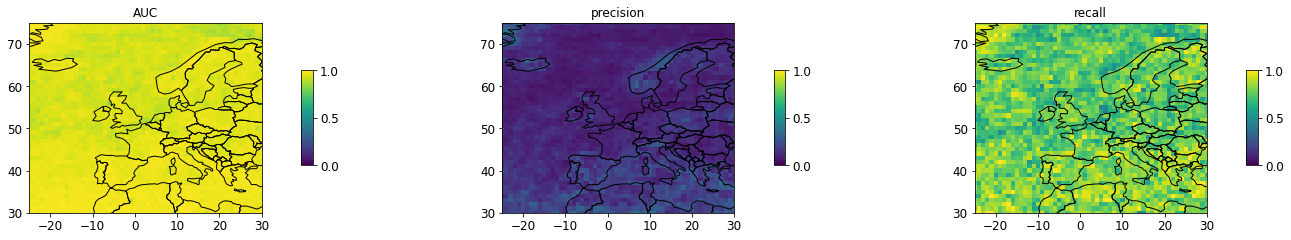

In [32]:
fig, axes = plt.subplots(figsize=(24, 3.5), ncols=3, nrows=1)
plot_map(axes[0], lons_y, lats_y, auc, title="AUC", vmin=0, vmax=1)
plot_map(axes[1], lons_y, lats_y, precision, title="precision", vmin=0, vmax=1)
plot_map(axes[2], lons_y, lats_y, recall, title="recall", vmin=0, vmax=1)

In [33]:
# Metrics-Spatially averages 
metrics_prec_xtrm = pd.DataFrame([(auc.mean().values, recall.mean().values, precision.mean().values)], columns=['auc', 'recall', 'precision'])

In [ ]:
# Reshape predictions to create maps
preds_reshaped = np.zeros(dg_test.y.shape)

...

# Train a random forest regressor

In [ ]:
# adapt similar functions to the classification case

In [15]:
X_train_dask = dg_train.X.chunk(chunk)
y_train_dask = dg_train.y.chunk(chunk)

In [16]:
%%time
rfs = xr.apply_ufunc(
    train_rf_regress_model,
    X_train_dask, y_train_dask,
    vectorize=True,
    dask = 'parallelized',
    input_core_dims=[['time', 'level'], ['time']],  # reduce along these dimensions
    output_dtypes=[object]
).compute()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [18]:
# save the models
with open('tmp/trained_regressors_RF_.pkl', 'wb') as output:
        pickle.dump(rfs, output, pickle.HIGHEST_PROTOCOL)

In [19]:
#open models
with open('tmp/trained_regressors_RF_.pkl', 'rb') as f:
    rfs = pickle.load(f)

In [58]:
    
def apply_rf_regress_model(rgf, X):
    try:
        print('|', end='')
        pred = rgf.predict(X) 
        return pd.DataFrame(pred)
    except:
        return None

In [43]:
r1= train_rf_regress_model(X_train_dask[:,0,0,:], y_train_dask[:,0,0])

|

In [54]:
pp= r1.predict(dg_test.X[:,0,0,:])

In [59]:
# calculate predictions
preds_reg = xr.apply_ufunc(
    apply_rf_regress_model, 
    rfs, dg_test.X,
    vectorize=True,
    input_core_dims=[[],['time', 'level']],
    output_core_dims=[[]],
    output_dtypes=[object] # change the output type
).compute()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [40]:
#evaluate--check --not working
mse = xr.apply_ufunc(
    eval_rf_mse, 
    rfs, dg_test.X,dg_test.y,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[object] # change the output type
).compute()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

TypeError: 'AxesSubplot' object is not subscriptable

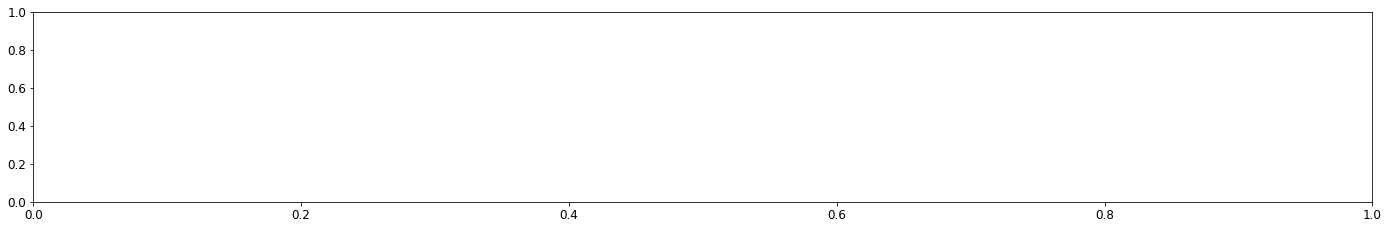

In [38]:
fig, axes = plt.subplots(figsize=(12, 3.5), ncols=1, nrows=1)
plot_map(axes[0], lons_y, lats_y, mse, title="MSE", vmin=0, vmax=1)

# Predict and assess on the test period

In [ ]:
def analyze_predictions(y_pred, dg, qq, pred_xtrm=False, show_plots=True, plot_most_extreme=True, plot_worst_best=False, plot_scores=True, plot_confusion_components=True):
    if pred_xtrm:
        y_pred_bool = y_pred >= 0.5
    else:
        y_pred_bool = y_pred > qq.to_numpy().squeeze()
        
    # Multiply to transorm to numeric values
    y_pred_bool = y_pred_bool * 1
    
    # Extract true values
    y_xtrm = dg.y_xtrm.to_numpy().squeeze()
    y_prec = dg.y.to_numpy().squeeze()
    
    # Get the index of the max # of extremes
    i_max_obs = np.argmax(np.sum(y_xtrm, axis=(1,2)))
    
    if show_plots and plot_most_extreme:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(12, 3.5), ncols=2, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_max_obs], title="Day with max # extremes - truth (xtrm)", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_max_obs], title="Day with max # extremes - prediction (prob xtrm)", vmin=0, vmax=1)
        else:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            vmax = max(np.max(y_prec[i_max_obs]), np.max(y_pred[i_max_obs]))
            plot_map(axes[0], lons_y, lats_y, y_prec[i_max_obs], title="Day with max # extremes - truth (val)", vmin=0, vmax=vmax)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_max_obs], title="Day with max # extremes - prediction (val)", vmin=0, vmax=vmax)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_max_obs], title="Day with max # extremes - truth (xtrm)", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred_bool[i_max_obs], title="Day with max # extremes - prediction (xtrm)", vmin=0, vmax=1)
        
    # Get the index of the max/min difference between prediction and obs
    y_diffs_series = np.sum(np.absolute(y_xtrm - y_pred_bool), axis=(1,2))
    i_worst_pred = np.argmax(y_diffs_series)
    i_best_pred = np.argmin(y_diffs_series)
    
    if show_plots and plot_worst_best:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_worst_pred], title="Worst prediction - truth", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_worst_pred], title="Worst prediction - prediction", vmin=0, vmax=1)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_best_pred], title="Best prediction - truth", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred[i_best_pred], title="Best prediction - prediction", vmin=0, vmax=1)
        else:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_worst_pred], title="Worst prediction - truth", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred_bool[i_worst_pred], title="Worst prediction - prediction", vmin=0, vmax=1)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_best_pred], title="Best prediction - truth", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred_bool[i_best_pred], title="Best prediction - prediction", vmin=0, vmax=1)
    
    # Compute scores
    precision, recall = eval_confusion_matrix_scores_on_map(y_xtrm, y_pred_bool)

    if pred_xtrm:
        roc_auc = eval_roc_auc_score_on_map(y_xtrm, y_pred)
        
    if show_plots and plot_scores:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(18, 4), ncols=3, nrows=1)
        else:
            fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)

        plot_map(axes[0], lons_y, lats_y, precision, title="Precision", vmin=0, vmax=1)
        plot_map(axes[1], lons_y, lats_y, recall, title="Recall", vmin=0, vmax=1)
        if pred_xtrm:
            plot_map(axes[2], lons_y, lats_y, roc_auc, title="ROC AUC", vmin=0.5, vmax=1)

    if show_plots and plot_confusion_components:
        tn, fp, fn, tp = eval_confusion_matrix_on_map(y_xtrm, y_pred_bool)
        fig, axes = plt.subplots(figsize=(24, 4), ncols=4, nrows=1)
        plot_map(axes[0], lons_y, lats_y, tn, title="True negative")
        plot_map(axes[1], lons_y, lats_y, fp, title="False positive")
        plot_map(axes[2], lons_y, lats_y, fn, title="False negative")
        plot_map(axes[3], lons_y, lats_y, tp, title="True positive")
    
    plt.show()
    
    if pred_xtrm:
        return np.mean(precision), np.mean(recall), np.mean(roc_auc)
    
    return np.mean(precision), np.mean(recall)

In [ ]:
# Predict the amount of precipitation
df_prec = pd.DataFrame(columns = ['id', 'name', 'opt_model',
                                  'train_pr_rmse', 'test_pr_rmse', 
                                  'train_xtrm_precision', 'test_xtrm_precision', 
                                  'train_xtrm_recall', 'test_xtrm_recall'])
df_xtrm = pd.DataFrame(columns = ['id', 'name', 'opt_model',
                                  'train_xtrm_roc_auc', 'test_xtrm_roc_auc', 
                                  'train_xtrm_precision', 'test_xtrm_precision', 
                                  'train_xtrm_recall', 'test_xtrm_recall'])

apply_for_prec = False
apply_for_xtrm = True


if apply_for_prec:
    print('To be implemented.')
    
if apply_for_xtrm:
    print('To be implemented.')
    


In [ ]:
df_prec

In [ ]:
df_xtrm